In [1]:
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git

fatal: destination path 'dog-cat-full-dataset' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.3.0


In [3]:
test_data_dir = '/content/dog-cat-full-dataset/data/test'
train_data_dir = '/content/dog-cat-full-dataset/data/train'

In [4]:
img_width = 32
img_height = 32
batch_size = 32

In [5]:

# create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
                rescale = 1./255,
    zoom_range=0.2, validation_split=.20,horizontal_flip=True
)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
train_generator = train_datagen.flow_from_directory(directory=train_data_dir,
                                              target_size = (img_width, img_height),
                                              classes = ['dogs', 'cats'],
                                              class_mode = 'binary',
                                              batch_size=30,
                                              subset='training')
validation_generator = train_datagen.flow_from_directory(directory=train_data_dir,
                                                   target_size = (32, 32),
                                                   classes = ['dogs', 'cats'],
                                                   class_mode = 'binary',
                                                   batch_size = batch_size,
                                                    subset ='validation')

test_generator = test_datagen.flow_from_directory(directory=test_data_dir,
                                                   target_size = (32, 32),
                                                   classes = ['dogs', 'cats'],
                                                   class_mode = 'binary',
                                                  
                                                   batch_size = batch_size)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape = (img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [8]:
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

In [9]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 10, 
                              validation_data= validation_generator,
                              validation_steps= validation_generator.n // 32
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
500/500 [==============================] - 50s 99ms/step - loss: 0.7568 - acc: 0.5991 - val_loss: 0.6349 - val_acc: 0.6447
Epoch 2/10
500/500 [==============================] - 50s 100ms/step - loss: 0.6297 - acc: 0.6512 - val_loss: 0.6092 - val_acc: 0.6678
Epoch 3/10
500/500 [==============================] - 50s 100ms/step - loss: 0.5949 - acc: 0.6792 - val_loss: 0.5840 - val_acc: 0.6808
Epoch 4/10
500/500 [==============================] - 50s 99ms/step - loss: 0.5693 - acc: 0.7035 - val_loss: 0.5429 - val_acc: 0.7172
Epoch 5/10
500/500 [==============================] - 50s 100ms/step - loss: 0.5507 - acc: 0.7196 - val_loss: 0.5290 - val_acc: 0.7410
Epoch 6/10
500/500 [==============================] - 50s 101ms/step - loss: 0.5348 - acc: 0.7305 - val_loss: 0.5629 - val_acc: 0.7085
Epoch 7/10
500/500 [==============================] - 50s 99ms/step - loss: 0.5149 - acc: 0.7433 - val_loss: 0.4833 

In [10]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)



Instructions for updating:
Please use Model.evaluate, which supports generators.
156/156 [==============================] - 11s 73ms/step - loss: 0.5126 - acc: 0.7438


In [11]:
# load images and their predictions 
import os
import PIL
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2
# assign label names to the corresponding indexes
labels = {0: 'cats', 1: 'dogs'}
prediction = []
original = []
image = []
count = 0
for i in os.listdir('/content/dog-cat-full-dataset/data/test'):
  for item in os.listdir(os.path.join('/content/dog-cat-full-dataset/data/test', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('/content/dog-cat-full-dataset/data/test', i, item))
    # resizing the image to (128,128)
    img = img.resize((32, 32))
    # appending image to the image list
    image.append(img)
    # converting image to array
    img = np.asarray(img, dtype = np.float32)
    # normalizing the image
    img = img / 255
    # reshaping the image into a 4D array
    img = img.reshape(-1, 32, 32, 3)
    # making prediction of the model
    predict = model.predict(img)
    # getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    # appending the predicted class to the list
    prediction.append(labels[predict])
    # appending original class to the list
    original.append(i)


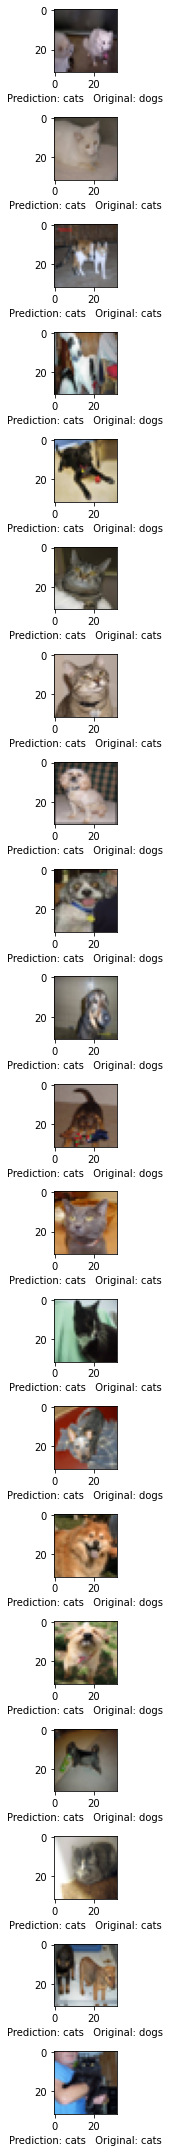

In [12]:
# visualize the results
import random
fig = plt.figure(figsize = (30,30))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [15]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [16]:
# Get list of layers from model
layer_outputs = [layer.output for layer in model.layers[1:]]

In [17]:
# Create a visualization model
visualize_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)

In [18]:
# Load image for prediction
img=load_img('/content/dog-cat-full-dataset/data/test/dogs/dog.0.jpg',target_size=(32,32))

In [19]:
# Convert image to array
x = img_to_array(img)

In [20]:
# Print shape of array
x.shape

(32, 32, 3)

In [21]:
# Reshape image for passing it to prediction
x=x.reshape((1,32,32,3))
print(x.shape)

(1, 32, 32, 3)


In [22]:
# Rescale the image
x = x /255 

In [23]:
# Get all layers feature maps for image
feature_maps=visualize_model.predict(x)
print(len(feature_maps))

20


In [24]:
# Show names of layers available in model
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['conv2d', 'batch_normalization', 'max_pooling2d', 'dropout', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'dropout_1', 'conv2d_2', 'batch_normalization_2', 'max_pooling2d_2', 'dropout_2', 'conv2d_3', 'batch_normalization_3', 'max_pooling2d_3', 'dropout_3', 'flatten', 'dense', 'batch_normalization_4', 'dropout_4', 'dense_1']


(1, 32, 32, 32)
(1, 16, 16, 32)
(1, 16, 16, 32)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 4, 4, 128)
(1, 4, 4, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 2, 2, 256)
(1, 2, 2, 256)
(1, 1024)
(1, 128)
(1, 128)
(1, 128)
(1, 1)


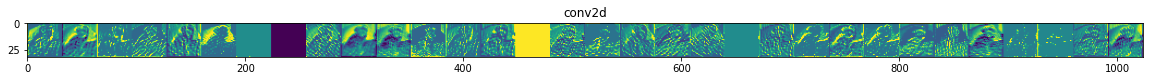

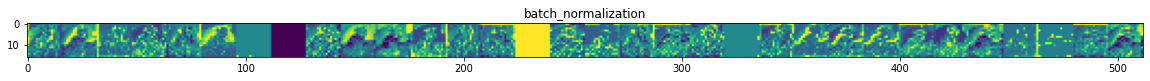

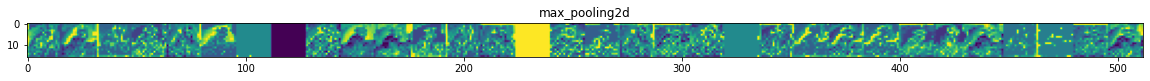

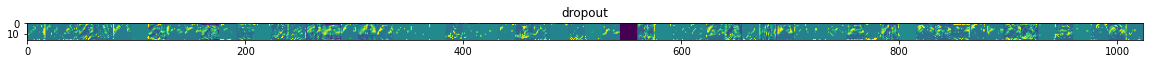

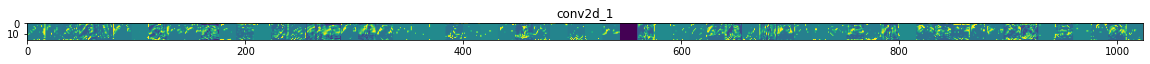

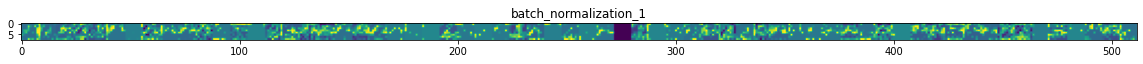

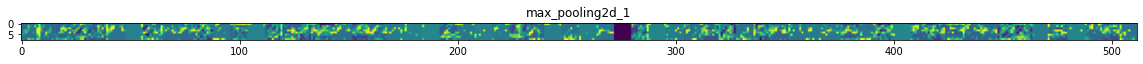

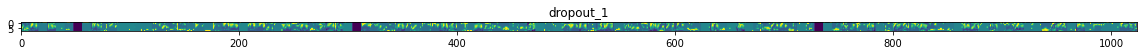

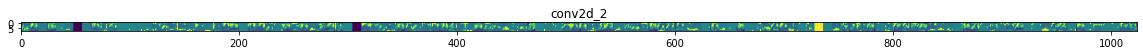

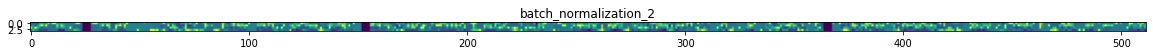

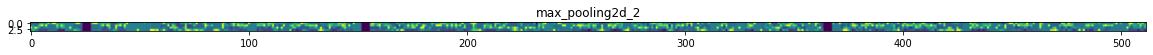

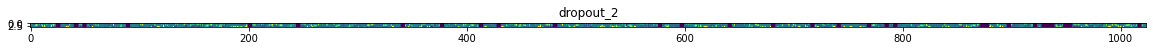

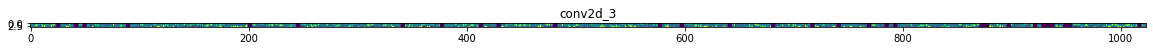

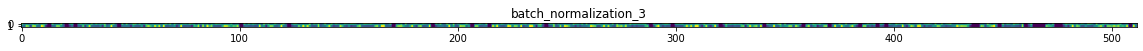

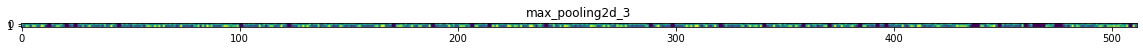

In [25]:
# Plotting the graph
for layer_names, feature_maps in zip(layer_names,feature_maps):
  print(feature_maps.shape)
  if len(feature_maps.shape) == 4 :
    channels = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * channels))
    for i in range(channels):
      x = feature_maps[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / channels
    plt.figure(figsize=(scale * channels, scale))
    plt.title(layer_names)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [26]:
filters = model.layers[2].get_weights()

In [27]:
print(filters)

[]


conv2d
32


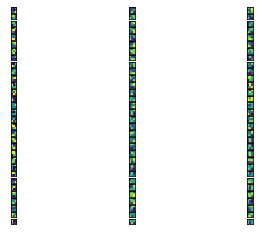

conv2d_1
64


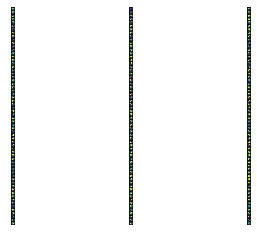

conv2d_2
128


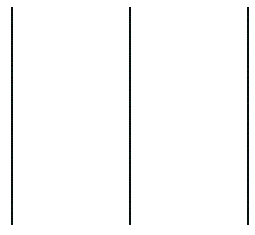

conv2d_3
256


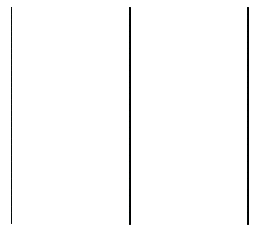

In [28]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

[[0.]]
prediction Dog


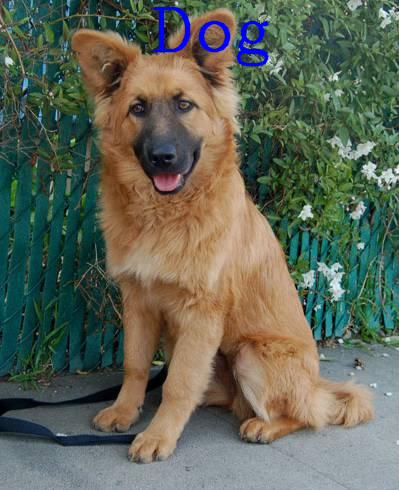

In [29]:
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow


img_pred = image.load_img("/content/dog-cat-full-dataset/data/test/dogs/dog.10014.jpg",target_size=(32,32))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred,axis=0)
rslt = model.predict(img_pred)
print(rslt)
prediction = ""
if rslt[0][0] == 1:
  prediction = 'Cat'
else:
  prediction = 'Dog'
print('prediction',prediction)

path = r"/content/dog-cat-full-dataset/data/test/dogs/dog.10014.jpg"
image = cv2.imread(path)
window_name = 'Image'
font = cv2.FONT_HERSHEY_COMPLEX
org = (150,50)
fontScale = 2
color = (255,0,0)
thickness = 2
image = cv2.putText(image,prediction,org,font,fontScale,color,thickness,cv2.LINE_AA)
cv2_imshow(image)